In [96]:
# Implimentation of a language model from the following research paper:
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [98]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
VOCAB_SIZE = len(stoi.keys())
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [99]:
BLOCK_SIZE = 3  # Context length.  How many letters do we take to predict the next.

# Build a data set.
def build_dataset(words): 
    """Build a data set from the given data.
  
    Returns: 
      torch.tensor: X inputs (context block_size long)
      torch.tensor: Y labels
    """
    X, Y = [], []
  
    for w in words:
        context = [0] * BLOCK_SIZE
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [100]:
# Going to split the training set.
n1 = int(0.8*len(words))  # 80% for training.
n2 = int(0.9*len(words))  # 10% for dev, and then 10% for eval.

import random
random.seed(42)
random.shuffle(words)
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [101]:
# We need to embed the inputs into a smaller tensor, since in practice the 
# number of input possibilities could be huge (27,000 in the case of words).
# So we need a "feature vector" that maps each context.  So a given context
# will get mapped into a feature vector.  We don't know what the feature 
# vector will be, so we will need to train it.  We will start it off as random
# numbers.  The shape must be NUM_POSSIBLE_WORDS by NUM_DIM_FEATURE_VEC
# The number of dimensions in the feature vector should be far smaller than
# the number of possible inputs.  
EMBED_SIZE = 10
L1_INPUT_SIZE = EMBED_SIZE * BLOCK_SIZE

# Let's build the full network.
# Layer 0 = embedding
# Layer 1 = number of neurons in hidden layer
# Layer 2 = fully connected that results in VOCAB_SIZE output probabilities
NUM_HIDDEN_NEURONS = 200
g = torch.Generator().manual_seed(1337) # for reproducibility

C = torch.randn((VOCAB_SIZE, EMBED_SIZE),             generator=g)
W1 = torch.randn((L1_INPUT_SIZE, NUM_HIDDEN_NEURONS), generator=g)
b1 = torch.randn(NUM_HIDDEN_NEURONS,                  generator=g)
W2 = torch.randn((NUM_HIDDEN_NEURONS, VOCAB_SIZE),    generator=g)
b2 = torch.randn(VOCAB_SIZE,                          generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


11897


In [102]:
for train_count in range(1):
    # Build a small batch of training data.  We want to select random items from our
    # huge training set.  So use random int to pick 32 items out of our huge list.
    batch_indexs = torch.randint(0, X.shape[0], (32,))

    # Forward pass.
    embedding = C[X[batch_indexs]]
    h_pre_act = embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1  # Pre-activation of h
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2

    # These next three are "grading" the system.  Classification is a typical AI task,
    # so they call the grading against truth "cross entropy".  We can just use the function.
    # Using the function in torch is far more efficient than calculating all of the intermediate
    # values and doing the math explicitly.
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y[batch_indexs])

    # Backward pass.
    TRAINING_RATE = 0.1

    # First reset the gradient on all params.
    for p in parameters:
        p.grad = None
    loss.backward()
    # Update values.
    for p in parameters:
        p.data += -TRAINING_RATE * p.grad
print(loss.item())

31.320106506347656


In [103]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    """Simple function to take a split of the data and compute the loss.  No
    gradients will be calculated."""
    x,y = {
        'train': (Xtr,  Ytr),
        'val'  : (Xdev, Ydev),
        'test' : (Xte,  Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h_pre_act = embcat @ W1 # + b1  # h pre-activation
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    #hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(h_pre_act) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 27.23516845703125
val 27.208059310913086


After the very first iteration, we have terrible loss.  Would have expected 3 to 4, but got 27.  So the softmax is way too confident.  It looks like the h X W2 is producint huge numbers.  So we need to scale down W2 and b2 so that the logits start off as small numbers.

In [104]:
# Let's rebuild with scaling on the last layer.
g = torch.Generator().manual_seed(1337) # for reproducibility

C = torch.randn((VOCAB_SIZE, EMBED_SIZE),             generator=g)
W1 = torch.randn((L1_INPUT_SIZE, NUM_HIDDEN_NEURONS), generator=g)
b1 = torch.randn(NUM_HIDDEN_NEURONS,                  generator=g)
W2 = torch.randn((NUM_HIDDEN_NEURONS, VOCAB_SIZE),    generator=g) * 0.01
b2 = torch.randn(VOCAB_SIZE,                          generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

for train_count in range(1):
    batch_indexs = torch.randint(0, X.shape[0], (32,))
    # Forward pass.
    embedding = C[X[batch_indexs]]
    h_pre_act = embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1  # Pre-activation of h
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[batch_indexs])
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -TRAINING_RATE * p.grad
print(loss.item())
split_loss('train')
split_loss('val')

11897
3.361250638961792
train 3.2323813438415527
val 3.2322874069213867


That looks way better! Our first iteration should now be a much better starting point.

Next let's look at the very first layer through the non-linear step of tanh.

torch.Size([32, 200])


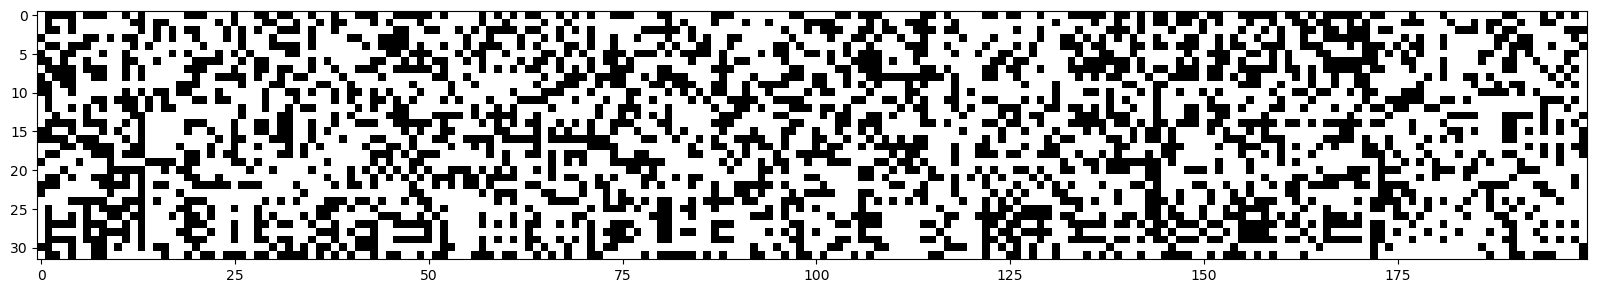

In [105]:
print(h.shape)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

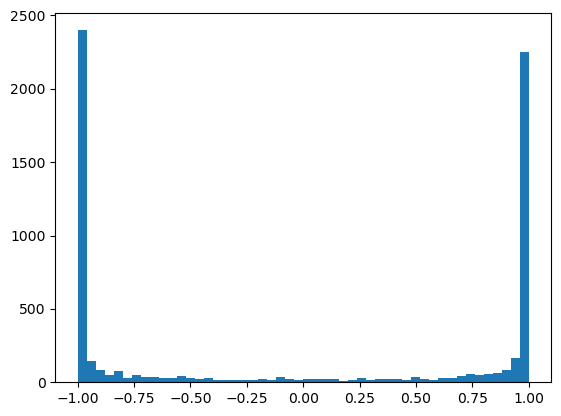

In [106]:
plt.hist(h.view(-1).tolist(), 50);

At this point we can see that the tanh function is getting tons of outputs way out at -1.0 and 1.0.  The trouble with this is that the neuron won't be able to learn anything since all the values are way out in the flat part of tanh.  In the plot above, any square that is white shows where the tanh is very close to one.  Those neurons will be "dead" and never contribute to learning.  The gradients can't flow past these neurons.

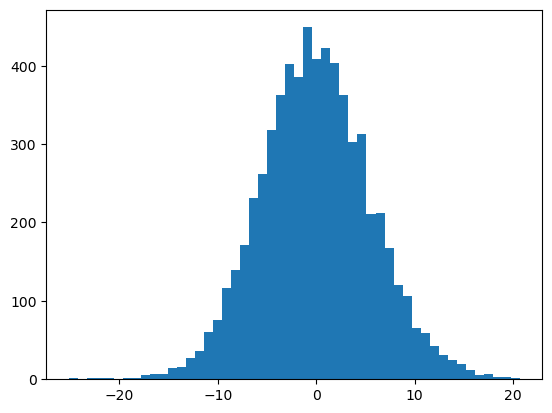

In [107]:
plt.hist(h_pre_act.view(-1).tolist(), 50);

We can see there are tons of values passed into tanh that are far from the -1 to 1.0 range where it provides gradients.  We need to get the pre-activation inputs down to the -1 to 1.0 range.  We can do this by scaling all of the initial weights by a small number.

In [108]:
# Let's rebuild the network with initialization scaling.

g = torch.Generator().manual_seed(1337) # for reproducibility

C = torch.randn((VOCAB_SIZE, EMBED_SIZE),             generator=g)
W1 = torch.randn((L1_INPUT_SIZE, NUM_HIDDEN_NEURONS), generator=g) * 0.01
b1 = torch.randn(NUM_HIDDEN_NEURONS,                  generator=g) * 0
W2 = torch.randn((NUM_HIDDEN_NEURONS, VOCAB_SIZE),    generator=g) * 0.01
b2 = torch.randn(VOCAB_SIZE,                          generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

for train_count in range(1000):
    batch_indexs = torch.randint(0, X.shape[0], (32,))
    # Forward pass.
    embedding = C[X[batch_indexs]]
    h_pre_act = embedding.view(-1, L1_INPUT_SIZE) @ W1 + b1  # Pre-activation of h
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[batch_indexs])
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -TRAINING_RATE * p.grad
print(loss.item())
split_loss('train')
split_loss('val')

11897
2.4072704315185547
train 2.5334086418151855
val 2.5311238765716553


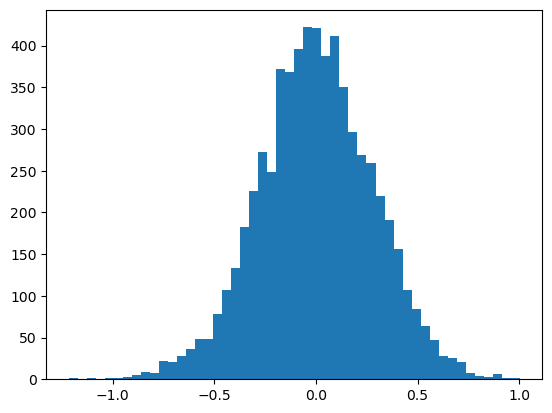

In [109]:
plt.hist(h_pre_act.view(-1).tolist(), 50);

These inputs to tanh are much better.  Also our training loss after 1000 iterations is much better.

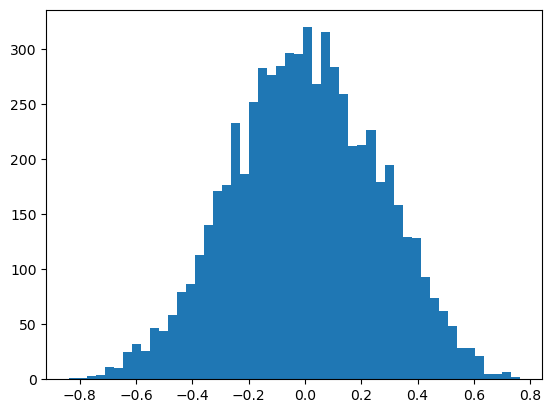

In [110]:
plt.hist(h.view(-1).tolist(), 50);

This output from tanh looks very good and will provide good gradients for training.

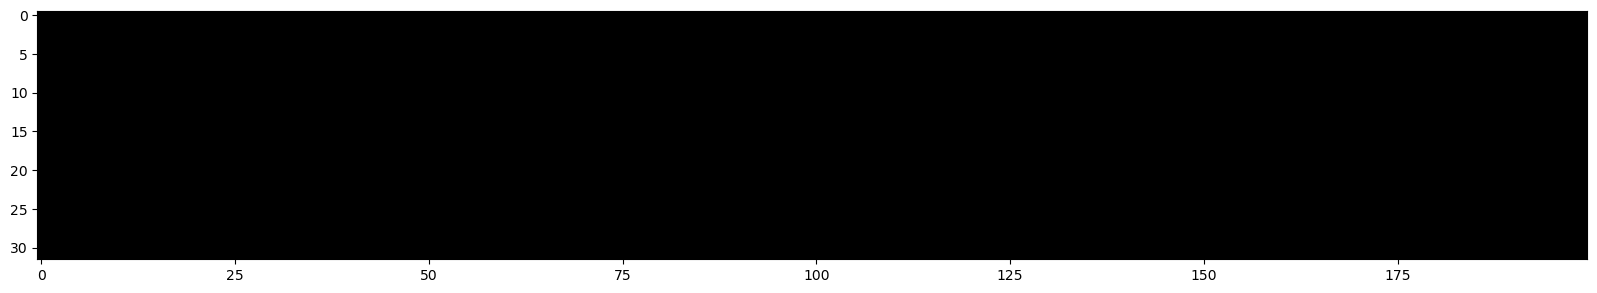

In [111]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Now there are no white spots.  So no neurons are saturated and stopping the gradients.

In these examples we just guessed at initial scales like 0.01.  Much research has been done on how to do it propely.  Much of the knowledge is now captured in things like torch.  So for init, we can look at:
https://pytorch.org/docs/stable/nn.init.html

We can see that when using tanh, the real scale should be (5/3)/(L1_INPUT_SIZE**0.5)
If we substitute that in, we will see basically the same result.  But going forward it's better to use the init system in torch instead of adding magic numbers.

One final thing we should look at is better normalization.  A key research paper came out in 2015 that detailed "Batch Normalization".  Lots of details on the wikipedia entry:
https://en.wikipedia.org/wiki/Batch_normalization 

The basic idea is that right before doing the nonlinear step, we can normalize the values that go into the nonlinear step.  It can be better than just hoping that the initial weight scales hold up.  This way every single time we call the nonlinear step we know for sure that we've sclaed values to get good gradients through the nonlinear step.  To make this work, we also need to track the running average as we go through all the training loops.  Those running averages should not be part of the backward steps or training.  But the weight that we give to the batch-norm step should be trainable, as well as the offset (bias) it needs.

In [112]:
# Let's rebuild using batch-norm.
g = torch.Generator().manual_seed(1337) # for reproducibility

C = torch.randn((VOCAB_SIZE, EMBED_SIZE),             generator=g)
W1 = torch.randn((L1_INPUT_SIZE, NUM_HIDDEN_NEURONS), generator=g) * 0.01
# No longer need b1 since batch-norm will take care of it.
W2 = torch.randn((NUM_HIDDEN_NEURONS, VOCAB_SIZE),    generator=g) * 0.01
b2 = torch.randn(VOCAB_SIZE,                          generator=g) * 0

# BatchNorm parameters
bn_gain = torch.ones( (1, NUM_HIDDEN_NEURONS))
bn_bias = torch.zeros((1, NUM_HIDDEN_NEURONS))
bn_mean_running = torch.zeros((1, NUM_HIDDEN_NEURONS))  # Not used for backward!
bn_std_running = torch.ones(  (1, NUM_HIDDEN_NEURONS))  # Not used for backward!

parameters = [C, W1, W2, b2, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

for train_count in range(5000):
    batch_indexs = torch.randint(0, X.shape[0], (32,))
    # Forward pass.
    embedding = C[X[batch_indexs]]
    h_pre_act = embedding.view(-1, L1_INPUT_SIZE) @ W1  # Pre-activation of h
    # BatchNorm layer
    bn_meani = h_pre_act.mean(0, keepdim=True)  # Mean along the batches.
    bn_stdi  = h_pre_act.std( 0, keepdim=True)
    h_pre_act = bn_gain * (h_pre_act - bn_meani) / bn_stdi + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_meani
        bn_std_running  = 0.999 * bn_std_running  + 0.001 * bn_stdi
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[batch_indexs])
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -TRAINING_RATE * p.grad
print(loss.item())
split_loss('train')
split_loss('val')

12097
2.2470149993896484
train 2.577434778213501
val 2.5762417316436768


In [113]:
# With a trained model we can now sample from it.

# g = torch.Generator().manual_seed(2147483647 + 1)

for _ in range(25):
    out = []
    context = [0] * BLOCK_SIZE
    while True:
        embedding = C[torch.tensor(context)]  # (1, block_size, d)
        h_pre_act = embedding.view(-1, L1_INPUT_SIZE) @ W1  # Pre-activation of h
        # BatchNorm layer
        h_pre_act = bn_gain * (h_pre_act - bn_mean_running) / bn_std_running + bn_bias
        h = torch.tanh(h_pre_act)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        next_letter_i = torch.multinomial(probs, num_samples=1, generator=g).item()
        if next_letter_i == 0:
            break
        out.append(itos[next_letter_i])
        context = context[1:] + [next_letter_i]
    print(''.join(out))

leik
azaurbelecen
pcardelinslani
japhia
ven
anghin
kicandanassamousasrie
duzely
bon
koreima
kasli
amera
leemanriakalex
pani
whav
fakeya
mmedelea
vaylenicians
siy
jayah
bremillyx
zylen
kaydbh
minielaniso
manuh


In [129]:
# As a bonus, let's make a network that looks more like what we would see where people are
# using torch, and make the network deeper.

# The classes we create here are the same API as nn.Module in PyTorch
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar  = x.var( 0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# Build the network
g = torch.Generator().manual_seed(2147483647) # for reproducibility
NUM_HIDDEN_NEURONS = 100

C = torch.randn((VOCAB_SIZE, EMBED_SIZE),            generator=g)
layers = [
    # Layer 1: Input from embeddings.
    Linear(L1_INPUT_SIZE, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 2
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 3
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 4
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Layer 5
    Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS, bias=False),
    BatchNorm1d(NUM_HIDDEN_NEURONS),
    Tanh(),
    # Output layer
    Linear(NUM_HIDDEN_NEURONS, VOCAB_SIZE, bias=False),
    BatchNorm1d(VOCAB_SIZE),
]
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Total params: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Total params:  47024


In [130]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

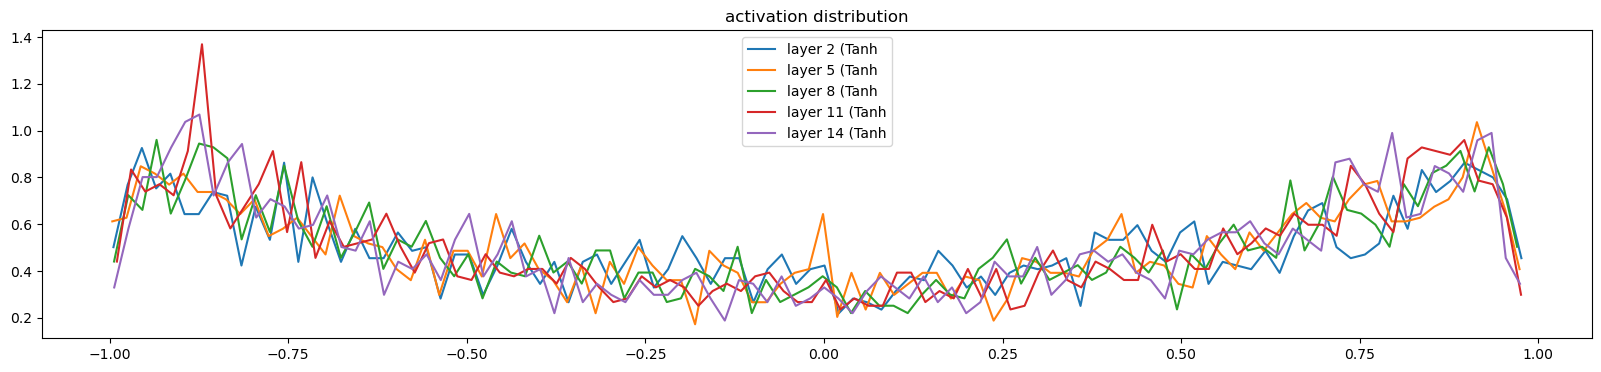

In [117]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640702e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

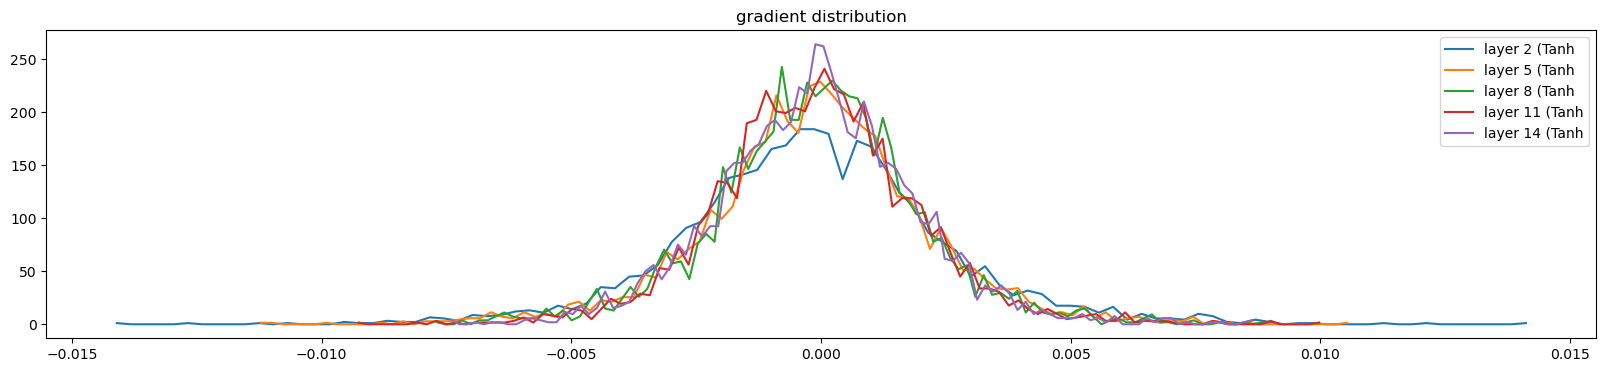

In [118]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020538e-03 | grad:data ratio 8.012635e-03
weight  (30, 100) | mean +0.000246 | std 9.241078e-03 | grad:data ratio 4.881091e-02
weight (100, 100) | mean +0.000113 | std 7.132879e-03 | grad:data ratio 6.964619e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742186e-03 | grad:data ratio 5.631481e-02
weight (100, 100) | mean +0.000032 | std 5.672206e-03 | grad:data ratio 5.570126e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


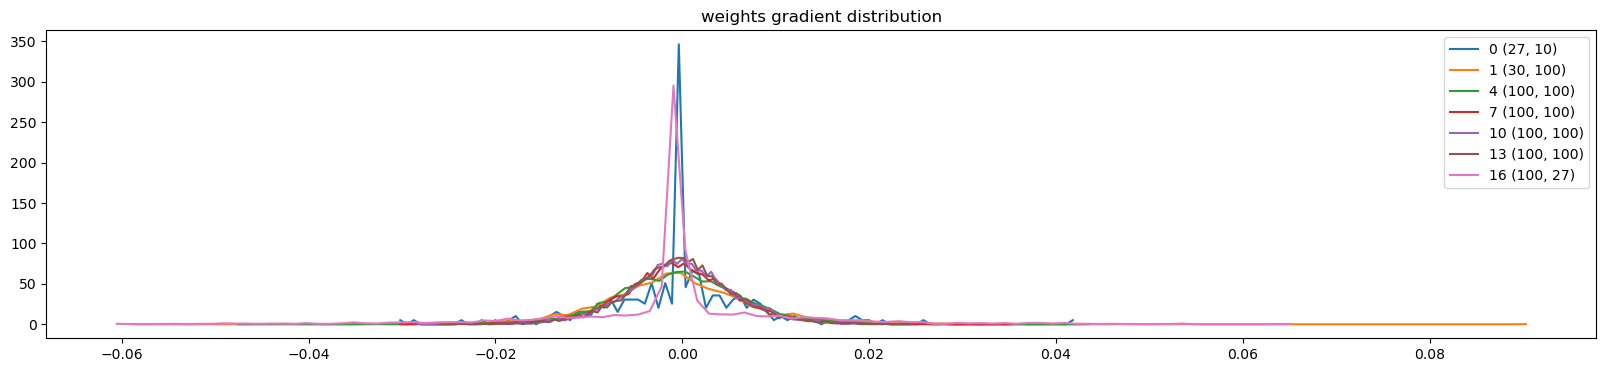

In [119]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [132]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for layer in layers:
   layer.training = False

for _ in range(20):
    
    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.
